### This notebook simply reads in the output from the linear models and plots the significant ROIs with coloring determined by which movie is greater. It generates surface plots. 

In [45]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy import stats
from scipy.stats import rankdata, ttest_rel, ttest_1samp, spearmanr, zscore
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_roi, plot_stat_map, view_img
import seaborn as sns
from nilearn.plotting import plot_glass_brain, plot_stat_map,  view_img, view_img_on_surf, plot_surf, plot_surf_stat_map, plot_surf_roi, plot_surf_contours, view_surf
import mantel
from nilearn.surface import vol_to_surf
from nilearn import datasets
from matplotlib.colors import LinearSegmentedColormap
import nibabel as nib
import warnings
warnings.filterwarnings("ignore")

fsaverage = datasets.fetch_surf_fsaverage()


# Defining functions

In [27]:
def color_rois(values):
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    data_dir = '../../data/'
    atlas_fname = (data_dir + '_masks/'+ 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz')
    schaeffer = nib.load(atlas_fname)
    schaeffer100_data = schaeffer.get_fdata()
    img = np.zeros(schaeffer100_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(schaeffer100_data==roi+1) 
        img[itemindex] = values[roi] # color them by the desired value 
    affine = schaeffer.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [28]:
def plot_surf_left(surf_mesh, view, fig, axes, cmap,colorbar,vmin, vmax,darkness, threshold):
    img = plotting.plot_surf_roi(surf_mesh, 
                        roi_map=surface_data['comp_labels'],
                        view = view,
                        cmap=cmap,
                        vmax=vmax, 
                        hemi='left',
                        threshold=threshold,

                        #vmin=np.nanmin(surface_data['comp_labels']),
                        vmin=vmin,
                        bg_map=fsaverage.sulc_left,
                        darkness=darkness,
                        bg_on_data=True,
                        title='',
                        figure = fig,
                        axes=axes,
                        colorbar=colorbar)
    return img
from matplotlib.pyplot import figure

def plot_surf_right(surf_mesh, view, fig, axes, cmap,colorbar,vmin, vmax,darkness, threshold):
    img = plotting.plot_surf_roi(surf_mesh, 
                        roi_map=surface_data['comp_labels'],
                        view = view,
                        cmap=cmap,
                        vmax=vmax, 
                        vmin=vmin,
                        hemi='right',
                        threshold=threshold,
                        #vmin=np.nanmin(surface_data['comp_labels']),
                        bg_map=fsaverage.sulc_right,
                        darkness=darkness,
                        bg_on_data=True,
                        title='',
                        figure = fig,
                        axes=axes,
                        colorbar=colorbar)
    return img
from matplotlib.pyplot import figure



In [29]:
def corr_matchz_mantel_bw_movies_contours(mov_x,mov_y):
    
    ''' This function is called to generate the correlation - "trait-like" similarity between movies. We run a mantel test, FDR correct, and then plot the ROIs that withstand this threshold'''
    ''' It runs a mantel test between the residuals from regressing the memory and motion out of the alignment matrices'''
    
    save_dir = '../../data/fig_2_4_neural_event_boundaries/_linear_models/'

    pval_list = []
    rval_list = []
    for node in range(1,101):
        a = np.load(save_dir + f'matchz+motionISCmotionAnnaKmemoryAnnaK_{mov_x}_output_vals.npy',allow_pickle=True).item()
        mov_x_res = a[node]['res']

        a = np.load(save_dir + f'matchz+motionISCmotionAnnaKmemoryAnnaK_{mov_y}_output_vals.npy',allow_pickle=True).item()
        mov_y_res = a[node]['res']

        r, p, z = mantel.test(mov_x_res,mov_y_res, method = 'spearman',  perms=10000)
    
    
        pval_list.append(p)
        rval_list.append(r)
    
    
    fdr_corrected_p = multipletests(pval_list,method='fdr_bh')[1]
    
    pos = []
    isrsa_plot = []
    val = []
    nodes_to_color = []
    for node in range(0,100):
        if fdr_corrected_p[node] > .05:
            isrsa_plot.append(np.nan)
            nodes_to_color.append(0)
        else:
            if rval_list[node]>0:
                pos.append(node)
                nodes_to_color.append(2)
                isrsa_plot.append(rval_list[node])
            else:
                print('this node is negative!',node,rval_list[node])
                isrsa_plot.append(np.nan)
                nodes_to_color.append(0)
    
    isrsa_mantel_r2_brain = color_rois(isrsa_plot)
    cont_plot = color_rois(nodes_to_color)
    return isrsa_mantel_r2_brain,cont_plot
    


In [30]:

def bootstrapped_diff_contours(mov_x,mov_y):

    ''' This function gets the ROIs to color for the difference between movie alignments, using the residuals after regressing out the memory and motion from the alignment difference'''
    
    node_OG = []
    pval_list = []
    for node in range(1,101):
        save_dir = '../../data/fig_2_4_neural_event_boundaries/_linear_models/'
        a = np.load(save_dir + f'matchz_diff+diff_motionISCdiff_motionAnnaKdiff_memoryAnnaK_{mov_x}_{mov_y}_output_vals.npy',allow_pickle=True).item()
        node_OG.append(a[node]['intercept'])
        pval_list.append(a[node]['p'])


    plotting_a = []
    ''' Account for p-values calcuated with different order'''
    fdr_corrected_p = multipletests(pval_list,method='fdr_bh')[1]
   

    listOf_reg = []
    nodes_to_color = []
    for i in range(100):
        if fdr_corrected_p[i] < .05:
            plotting_a.append(node_OG[i])
            listOf_reg.append(i)
            nodes_to_color.append(2)
        else:
            plotting_a.append(np.nan)
            nodes_to_color.append(0)

    event_value_to_plot = pd.Series(plotting_a)
    evt_plt = color_rois(event_value_to_plot)
    
    cont_plot = color_rois(nodes_to_color)

    return evt_plt,cont_plot



### Defining custom colors for each movie for plotting purposes. 
- Generating custom color maps too for the diff part of the plot


In [31]:

def get_color(x):
    if (x=='growth'):
        col_x='#00493E'
    elif x=='defeat':
        col_x = '#62000D'
    elif x=='iteration':
        col_x = '#0B0075'
    elif x=='lemonade':
        col_x = '#CE7700'
    return col_x

def get_color_lite(x):
    if (x=='growth'):
        col_x='#009780'
    elif x=='defeat':
        col_x = '#B8385D'
    elif x=='iteration':
        col_x = '#5D4B7D'
    elif x=='lemonade':
        col_x = '#E59F38'
    return col_x





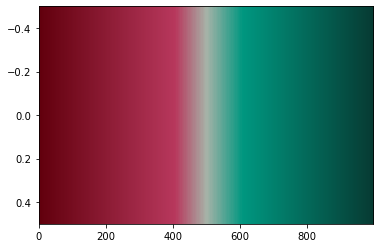

In [32]:
gro_def = LinearSegmentedColormap.from_list('gro_def', (
    # Edit this gradient at https://eltos.github.io/gradient/#gro_def=0:62000D-40.7:B8385D-50:A7B3A8-60.9:009780-100:073B33
    (0.000, (0.384, 0.000, 0.051)),
    (0.407, (0.722, 0.220, 0.365)),
    (0.500, (0.655, 0.702, 0.659)),
    (0.609, (0.000, 0.592, 0.502)),
    (1.000, (0.027, 0.231, 0.200))))
if __name__ == '__main__':
    
    plt.imshow([np.arange(1000)], aspect="auto", cmap=gro_def)
    plt.show()

In [33]:
gro_ite = LinearSegmentedColormap.from_list('gro_ite', (
    # Edit this gradient at https://eltos.github.io/gradient/#gro_ite=0:0B0075-40.1:5D4B7D-50:A0A0A4-62.2:009780-100:073B33
    (0.000, (0.043, 0.000, 0.459)),
    (0.401, (0.365, 0.294, 0.490)),
    (0.500, (0.627, 0.627, 0.643)),
    (0.622, (0.000, 0.592, 0.502)),
    (1.000, (0.027, 0.231, 0.200))))

def_ite = LinearSegmentedColormap.from_list('def_ite', (
    # Edit this gradient at https://eltos.github.io/gradient/#def_ite=0:0B0075-40.2:5D4B7D-50:917B7F-61.7:B8385D-100:62000D
    (0.000, (0.043, 0.000, 0.459)),
    (0.402, (0.365, 0.294, 0.490)),
    (0.500, (0.569, 0.482, 0.498)),
    (0.617, (0.722, 0.220, 0.365)),
    (1.000, (0.384, 0.000, 0.051))))

def_lem = LinearSegmentedColormap.from_list('def_lem', (
    # Edit this gradient at https://eltos.github.io/gradient/#def_lem=0:CE7700-40.3:E59F38-50:AA848C-61.1:B8385D-100:62000D
    (0.000, (0.808, 0.467, 0.000)),
    (0.403, (0.898, 0.624, 0.220)),
    (0.500, (0.667, 0.518, 0.549)),
    (0.611, (0.722, 0.220, 0.365)),
    (1.000, (0.384, 0.000, 0.051))))


gro_lem = LinearSegmentedColormap.from_list('gro_lem', (
    # Edit this gradient at https://eltos.github.io/gradient/#gro_lem=0:CE7700-41.4:E59F38-50:D1B384-61:009780-100:073B33
    (0.000, (0.808, 0.467, 0.000)),
    (0.414, (0.898, 0.624, 0.220)),
    (0.500, (0.820, 0.702, 0.518)),
    (0.610, (0.000, 0.592, 0.502)),
    (1.000, (0.027, 0.231, 0.200))))

ite_lem = LinearSegmentedColormap.from_list('ite_lem', (
    # Edit this gradient at https://eltos.github.io/gradient/#ite_lem=0:CE7700-39.2:E59F38-50:C4AA88-60.9:5D4B7D-100:0B0075
    (0.000, (0.808, 0.467, 0.000)),
    (0.392, (0.898, 0.624, 0.220)),
    (0.500, (0.769, 0.667, 0.533)),
    (0.609, (0.365, 0.294, 0.490)),
    (1.000, (0.043, 0.000, 0.459))))


In [34]:
def color_map(mov1,mov2):
    if mov1=='growth' and mov2=='defeat':
        cmap = gro_def
    if mov1=='growth' and mov2=='iteration':
        cmap = gro_ite
    if mov1=='growth' and mov2=='lemonade':
        cmap = gro_lem
    if mov1=='defeat' and mov2=='lemonade':
        cmap = def_lem
    if mov1=='defeat' and mov2=='iteration':
        cmap = def_ite
    if mov1=='iteration' and mov2=='lemonade':
        cmap = ite_lem

    return cmap
    

# Fig. 4b - Correlation: plot surf ROIs

this node is negative! 12 -0.1011122948099341
this node is negative! 72 -0.0912376629439259


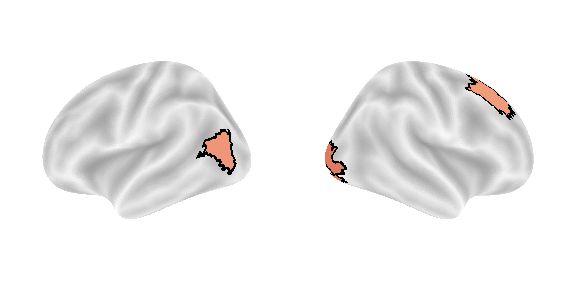

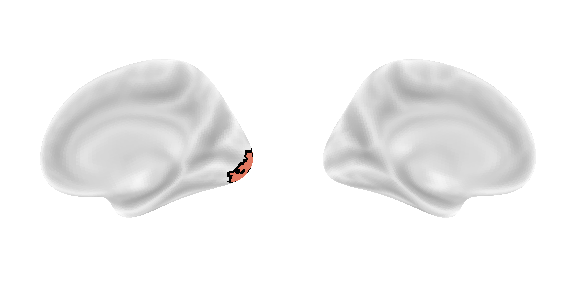

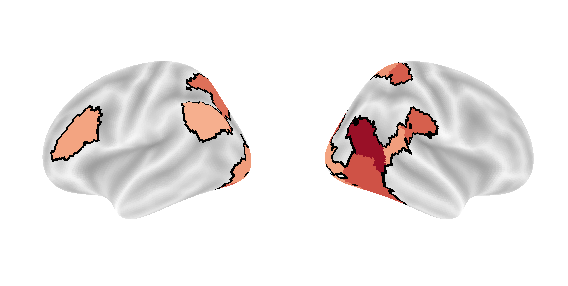

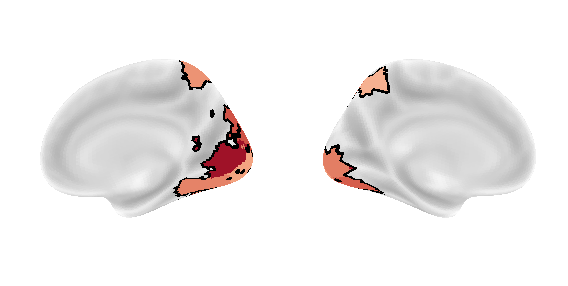

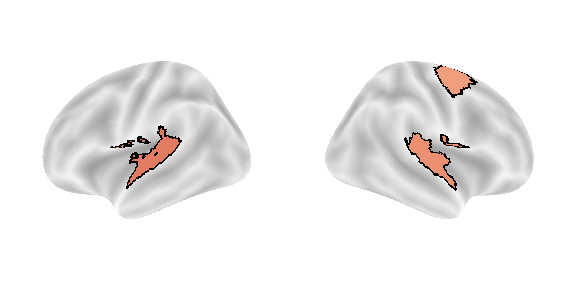

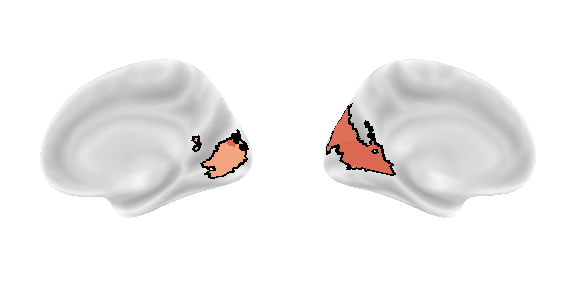

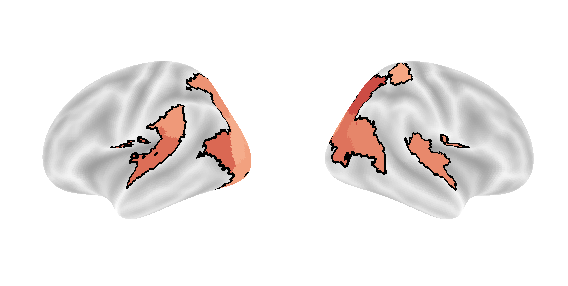

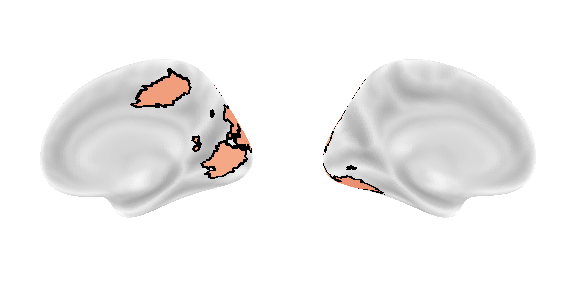

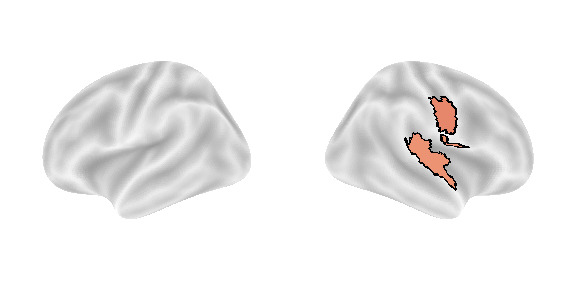

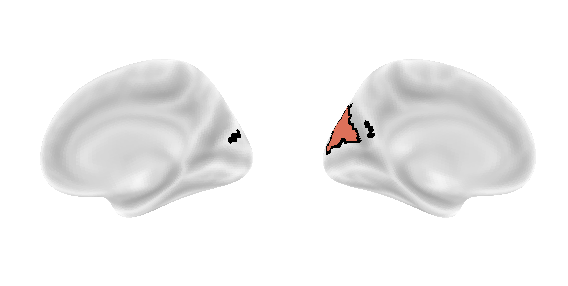

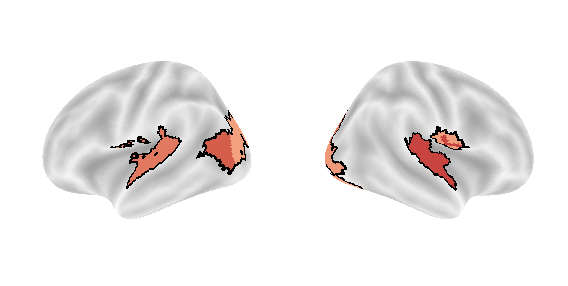

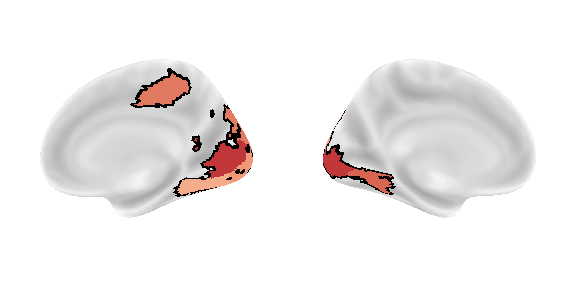

In [35]:


ay = 1
movies = ['growth','defeat','iteration','lemonade']

vmax = .25
vmin = -.25

for mov in movies[1:]:
    isrsa_mantel_r2_brain,cont_plot = corr_matchz_mantel_bw_movies_contours('growth',mov)
    cmap='RdBu_r'
    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_left,axes=ax[0],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1,legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_right,axes=ax[1],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1,axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None

    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes=ax[1],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, view='medial',axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None        
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes=ax[0],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot4,view='medial',axes=ax[0],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None

ay = 2
for mov in movies[2:]:

    isrsa_mantel_r2_brain,cont_plot = corr_matchz_mantel_bw_movies_contours('defeat',mov)
    cmap='RdBu_r'
    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_left,axes=ax[0],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1,legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None    
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_right,axes=ax[1],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1,axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None

    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes=ax[1],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, view='medial',axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None    
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes=ax[0],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot4,view='medial',axes=ax[0],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None
        
ay = 3
for mov in movies[3:]:
    isrsa_mantel_r2_brain,cont_plot = corr_matchz_mantel_bw_movies_contours('iteration',mov)
    cmap='RdBu_r'

    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_left,axes=ax[0],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1,legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_right,axes=ax[1],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1,axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None

    
    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes=ax[1],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, view='medial',axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None  
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)    
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes=ax[0],darkness=.4)
    try:
        texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot4,view='medial',axes=ax[0],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    except:
        None

    


# Fig. 4B. - Difference plot surf ROI

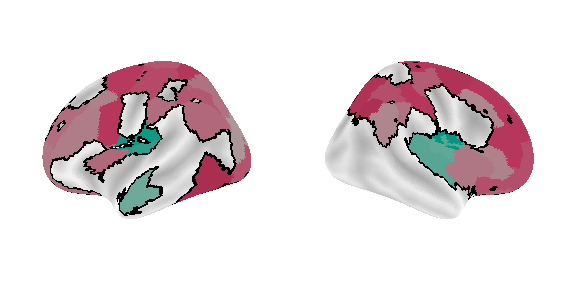

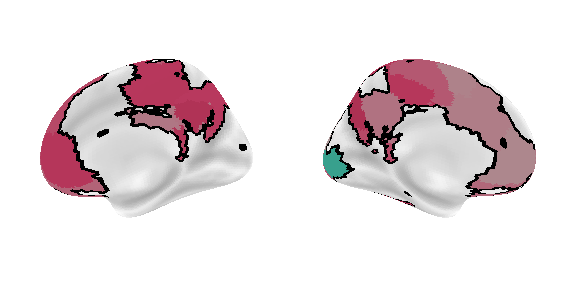

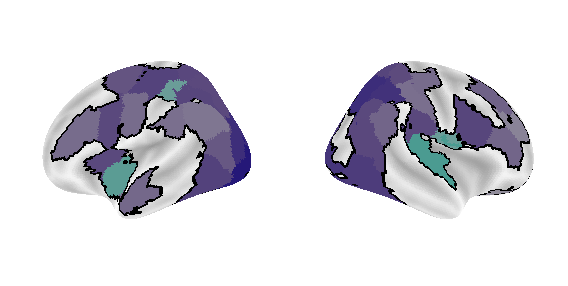

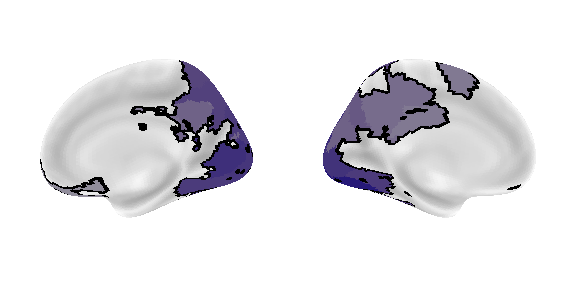

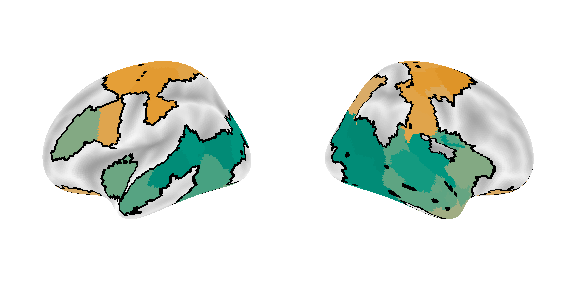

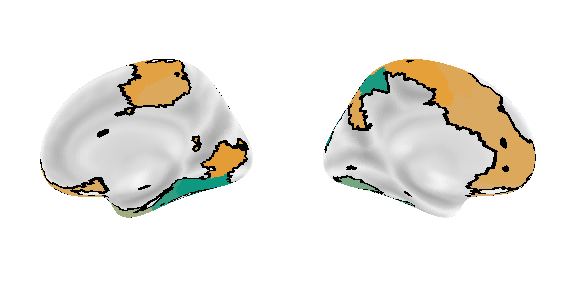

In [36]:
vmax = 1.75
vmin = -1.75
movies = ['growth','defeat','iteration','lemonade']

nodes_to_color = []
for node in range(100):
    nodes_to_color.append(1)


for mov in movies[1:]:
    isrsa_mantel_r2_brain,cont_plot = bootstrapped_diff_contours('growth',mov)
    cmap=color_map('growth',mov)
    
    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_left,axes=ax[0],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1,legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])

    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,  vmax = vmax, vmin=vmin,
                                 bg_map=fsaverage.sulc_right,axes=ax[1],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1,axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])

   
    
    
    #############################
    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes=ax[1],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, view='medial',axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
 
    
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmax = vmax, vmin=vmin,
                                bg_map=fsaverage.sulc_right, bg_on_data=False, view ='medial',axes=ax[0],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot4,view='medial',axes=ax[0],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])

        
    
    

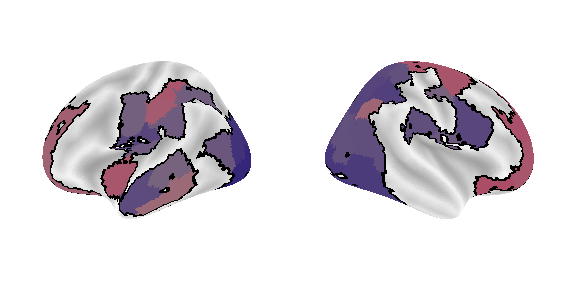

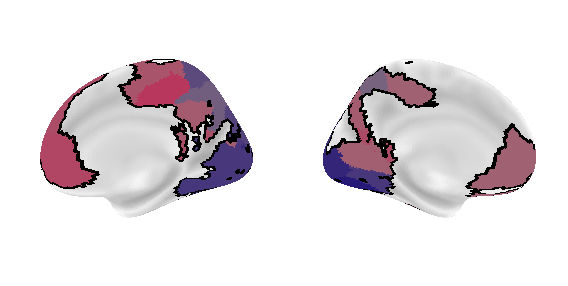

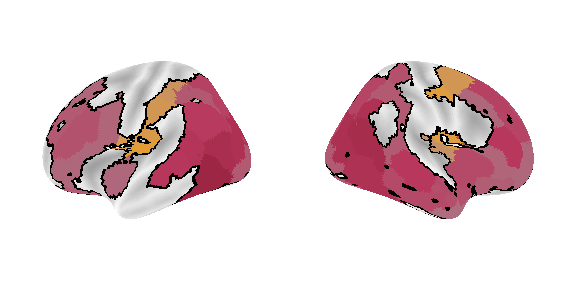

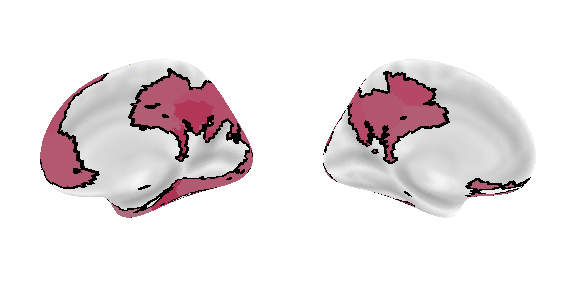

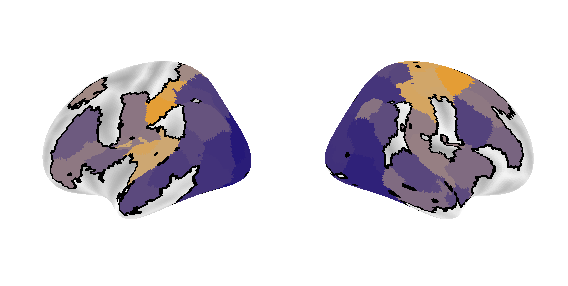

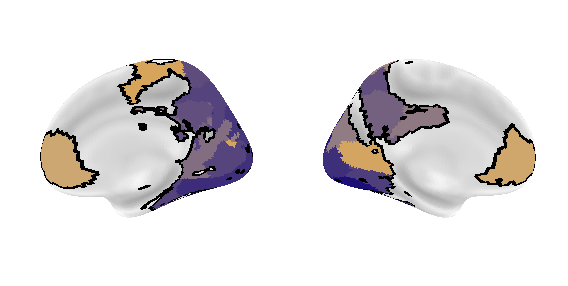

In [39]:


ay = 2
for mov in movies[2:]:
    isrsa_mantel_r2_brain,cont_plot = bootstrapped_diff_contours('defeat',mov)
    cmap=color_map('defeat',mov)
    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_left,axes=ax[0],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1,legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])

    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_right,axes=ax[1],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1,axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])


    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes=ax[1],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, view='medial',axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
  
    
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmax = vmax, vmin=vmin,
                                bg_map=fsaverage.sulc_right, bg_on_data=False, view ='medial',axes=ax[0],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot4,view='medial',axes=ax[0],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])


    
    
ay = 3
for mov in movies[3:]:
    isrsa_mantel_r2_brain,cont_plot = bootstrapped_diff_contours('iteration',mov)
    cmap=color_map('iteration',mov)
    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_left,axes=ax[0],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1,legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
   
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                                 bg_map=fsaverage.sulc_right,axes=ax[1],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1,axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])


    fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=None,w_pad=None)
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes=ax[1],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, view='medial',axes=ax[1],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
     
    
    texture = vol_to_surf(isrsa_mantel_r2_brain, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmax = vmax, vmin=vmin,
                                bg_map=fsaverage.sulc_right, bg_on_data=False, view ='medial',axes=ax[0],darkness=.4)
    texture = vol_to_surf(cont_plot, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot4,view='medial',axes=ax[0],legend=False, levels=[2],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])


    
    

# Diagonal - Distribution of values

### Defining Functions

In [48]:
def OG_med_list(mov_x):

    node_OG = []
    matchz_dict = np.load('../../data/event_seg/matchz_matrices_concat.npy',allow_pickle=True).item()
    for node in range(1,101):
        #get us the OG Value: 
        matchz_node = matchz_dict[mov_x][f'node_{node}']

        matchz_node_mean = matchz_node.copy()
        for i in range(matchz_node.shape[0]):
                for j in range(matchz_node.shape[0]):
                    matchz_node_mean[i,j] = np.mean([matchz_node[i,j],matchz_node[j,i]])
                    matchz_node_mean[j,i] = np.mean([matchz_node[i,j],matchz_node[j,i]])

        #### have the mean values to make the upper and lower triangles the same and how going to bootstrap them
        sample_n = matchz_node.shape[0]

        #### replaced the diagonal 0s with nan
        np.fill_diagonal(matchz_node_mean,np.nan)
        mov_x_mat = matchz_node_mean
        
        low_t_inds = np.tril_indices(sample_n, k=-1)
        OG_med = np.nanmedian(mov_x_mat[low_t_inds])
      
        node_OG.append(OG_med)

    
    return node_OG


In [40]:

def get_mov(mov_name,mov1,mov2,mov3,mov4):
    
    if mov_name == 'growth':
        mov = mov1
    if mov_name == 'defeat':
        mov = mov2
    if mov_name == 'iteration':
        mov = mov3
    if mov_name == 'lemonade':
        mov = mov4
    return mov

def mov_dist(mov_name,other_movs,mov1,mov2,mov3,mov4):
    ax = sns.distplot(get_mov(mov_name,mov1,mov2,mov3,mov4), hist = False, kde = True,
                 kde_kws = {'linewidth': 5, "alpha": 1},
                 label = mov_name,color=get_color(mov_name),fit_kws={"color":get_color(mov_name),"alpha":1})
    l1 = ax.lines[0]
    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    ax.fill_between(x1, y1, color=get_color(mov_name), alpha=0.3)

    
    ''' plot the other ones and not fill them in'''
    
    for j in other_movs:
        sns.distplot(get_mov(j,mov1,mov2,mov3,mov4), hist = False, kde = True,
                     kde_kws = {'linewidth': 5,'linestyle':'--',"alpha": 1},
                     label = j,color=get_color_lite(j),fit_kws={"color":get_color_lite(j),"alpha":1})




In [49]:
mov1 = OG_med_list('growth')
mov2 = OG_med_list('defeat')
mov3 = OG_med_list('iteration')
mov4 = OG_med_list('lemonade')



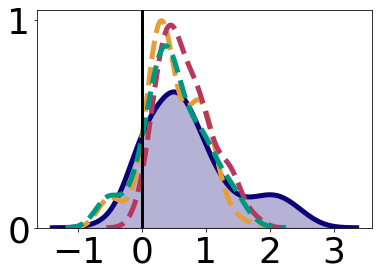

In [50]:
#Iteration

other_movs = ['lemonade','defeat','growth']
mov_dist('iteration',other_movs,mov1,mov2,mov3,mov4)

plt.ylabel('',color='w')

plt.yticks([0,1],fontsize=36)
plt.xticks([-1,0,1,2,3],fontsize=36)
plt.axvline(x=0,color='black',linewidth=3)


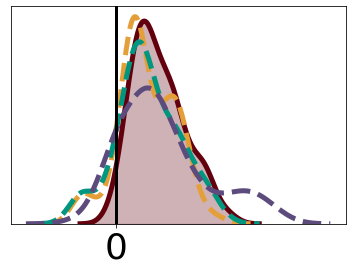

In [51]:
#Defeat

other_movs = ['lemonade','growth','iteration']

mov_dist('defeat',other_movs,mov1,mov2,mov3,mov4)
plt.ylabel('',color='w')

plt.xticks([0],fontsize=36)
plt.yticks([])
plt.axvline(x=0,color='black',linewidth=3)


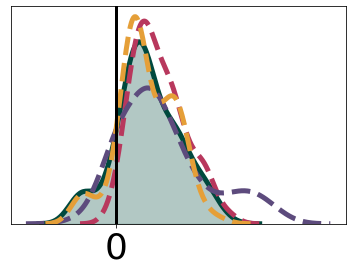

In [52]:
#Growth

other_movs = ['defeat','iteration','lemonade']

mov_dist('growth',other_movs,mov1,mov2,mov3,mov4)
plt.ylabel('',color='w')

plt.xticks([0],fontsize=36)
plt.yticks([])
plt.axvline(x=0,color='black',linewidth=3)


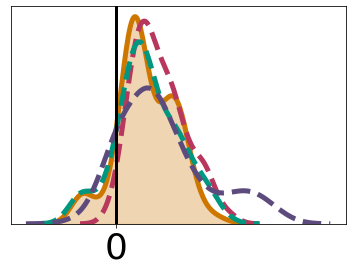

In [53]:
#Lemonade

other_movs = ['defeat','growth','iteration']

mov_dist('lemonade',other_movs,mov1,mov2,mov3,mov4)
plt.ylabel('',color='w')


plt.xticks([0],fontsize=36)
plt.yticks([])
plt.axvline(x=0,color='black',linewidth=3)
